# 

# LCMS

## Setup

In [ ]:
library(readxl)
library(data.table)
library(ggplot2)
library(patchwork)
library(here)


here() starts at C:/Users/alosvendsen/Documents/R/manuscript_one

## Donor 3, AS0013B, Midazolam

**Load data**

In [ ]:

# Ignore warnings. Just NA's as expected
data <-
  read_excel(
    path = here("notebooks/LCMS/data_raw/230628RAVERSION_Short.xlsx"),
    sheet = "Hydroxymidazolam",
    skip = 4,
    col_types = c(
      "text", "skip", "skip", "skip",
      "skip", "skip", "skip", "skip",
      "numeric", "skip", "skip", "text",
      "skip", "skip", "skip", "skip"
    ),
    col_names = c("sample_name", "amount", "peak_status")
  )


In [ ]:
sample_info <- read_excel(here("notebooks/LCMS/data_raw/AS0013B_sample_info.xlsx"))

tidy_data <- merge.data.table(data, sample_info, by = "sample_name")

# Check dt structure
str(tidy_data)


Classes 'data.table' and 'data.frame':  180 obs. of  9 variables:
 $ sample_name    : chr  "AS0013B_1" "AS0013B_10" "AS0013B_100" "AS0013B_101" ...
 $ amount         : num  7.3 17.58 18.04 6.55 7.57 ...
 $ peak_status    : chr  NA NA NA NA ...
 $ metabolite     : chr  "Hydroxymidazolam" "Hydroxymidazolam" "Hydroxymidazolam" "Hydroxymidazolam" ...
 $ donor          : num  3 3 3 3 3 3 3 3 3 3 ...
 $ treatment      : chr  "medium" "1 ng/ml IL-1B" "10 ng/ml IL-1B" "control" ...
 $ time_treatment : num  24 24 24 72 72 72 72 72 72 72 ...
 $ time_incubation: num  0.5 8 8 0.5 0.5 0.5 0.5 0.5 8 8 ...
 $ rep            : num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "sample_name"

Check peak status’ for any amounts below what below/above the limit of our standard curve.

In [ ]:
# Check peak status'
unique(tidy_data$peak_status)


[1] NA             "Response Low"

  -----------------------------------------------------------------------------------------------------------------------
  sample_name        amount peak_status   metabolite           donor treatment     time_treatment   time_incubation   rep
  ------------- ----------- ------------- ------------------ ------- ----------- ---------------- ----------------- -----
  AS0013B_113     0.0880969 Response Low  Hydroxymidazolam         3 10 ng/ml                 120               0.5     1
                                                                     IL-6                                           

  -----------------------------------------------------------------------------------------------------------------------


#### Should this be omitted? It is below the lowest point on our standard curve, but omitting it would make the mean higher, than it really is?

**Mean of replicates and activity relative to vehicle control**

In [ ]:
# Calculate the mean amount of replicates
tidy_data[, 
          mean_amount := mean(amount, na.rm = TRUE), 
          by = .(treatment, time_treatment, time_incubation)
          ]


# Add column with control mean amounts grouped by time_treatment and time_incubation
tidy_data[,
          control_mean_amount := mean(mean_amount[treatment == "control"]),
          by = .(time_treatment, time_incubation)
          ]

# Calculate both amounts and mean_amounts relative to control
tidy_data[,
          `:=`(
            relative_amount = amount / control_mean_amount,
            mean_relative_amount = mean_amount / control_mean_amount
            )
          ]


**Save the data**

In [ ]:
saveRDS(tidy_data, file = here("notebooks/LCMS/data_processed/AS0013.rds"))


#### **Plots**

In [ ]:
tidy_data <- readRDS(here("notebooks/LCMS/data_processed/AS0013.rds"))


In [ ]:
# Create groups/look up tables for subsetting data
group_IL6 <- c("control", 
               #"medium", 
               "0.01 ng/ml IL-6", 
               "0.1 ng/ml IL-6",
               "1 ng/ml IL-6", 
               "10 ng/ml IL-6"
               )

group_IL1B <- c("control", 
                #"medium", 
                "0.01 ng/ml IL-1B", 
                "0.1 ng/ml IL-1B",
                "1 ng/ml IL-1B",
                "10 ng/ml IL-1B"
                )


IL-6 effect on CYP3A4

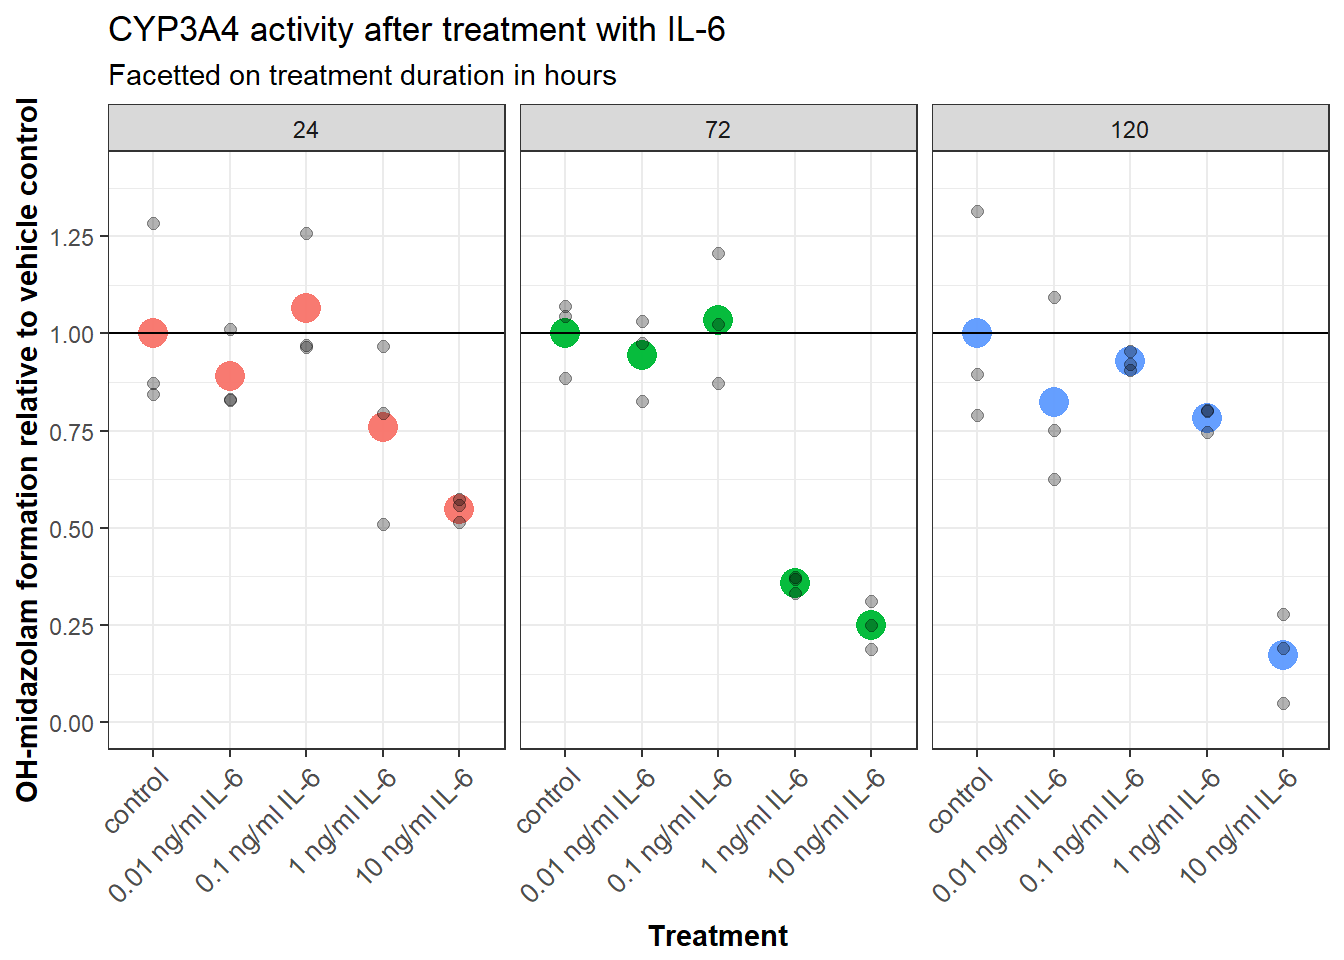

Saving 7 x 5 in image

In [ ]:
plot_data <- tidy_data[time_incubation == 0.5 &
  treatment %in% group_IL6]

act_3A4_IL_6_AS0013 <- 
ggplot(data = plot_data) +
  geom_point(
    aes(
      x = treatment,
      y = mean_relative_amount,
      color = factor(time_treatment)
    ),
    size = 5,
    alpha = 0.7
  ) +
  geom_point(
    aes(
      x = treatment,
      y = relative_amount
    ),
    size = 2,
    alpha = 0.3
  ) +
  geom_hline(yintercept = 1) +
  scale_y_continuous(
    name = "OH-midazolam formation relative to vehicle control", 
    breaks = seq(from = 0, to = 1.5, by= 0.25), limits = c(0, 1.4)
    ) +
  facet_wrap(
    facets = vars(factor(time_treatment))
  ) +
  theme_bw() +
  xlab("Treatment") + 
  ggtitle("CYP3A4 activity after treatment with IL-6",
          subtitle = "Facetted on treatment duration in hours") +
  ylab("Metabolite formation relative to vehicle control") +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
        axis.title.x = element_text(hjust = 0.5, vjust = 0, face = "bold"),
        axis.title.y = element_text(face = "bold"),
        legend.position = "none"
  )

act_3A4_IL_6_AS0013


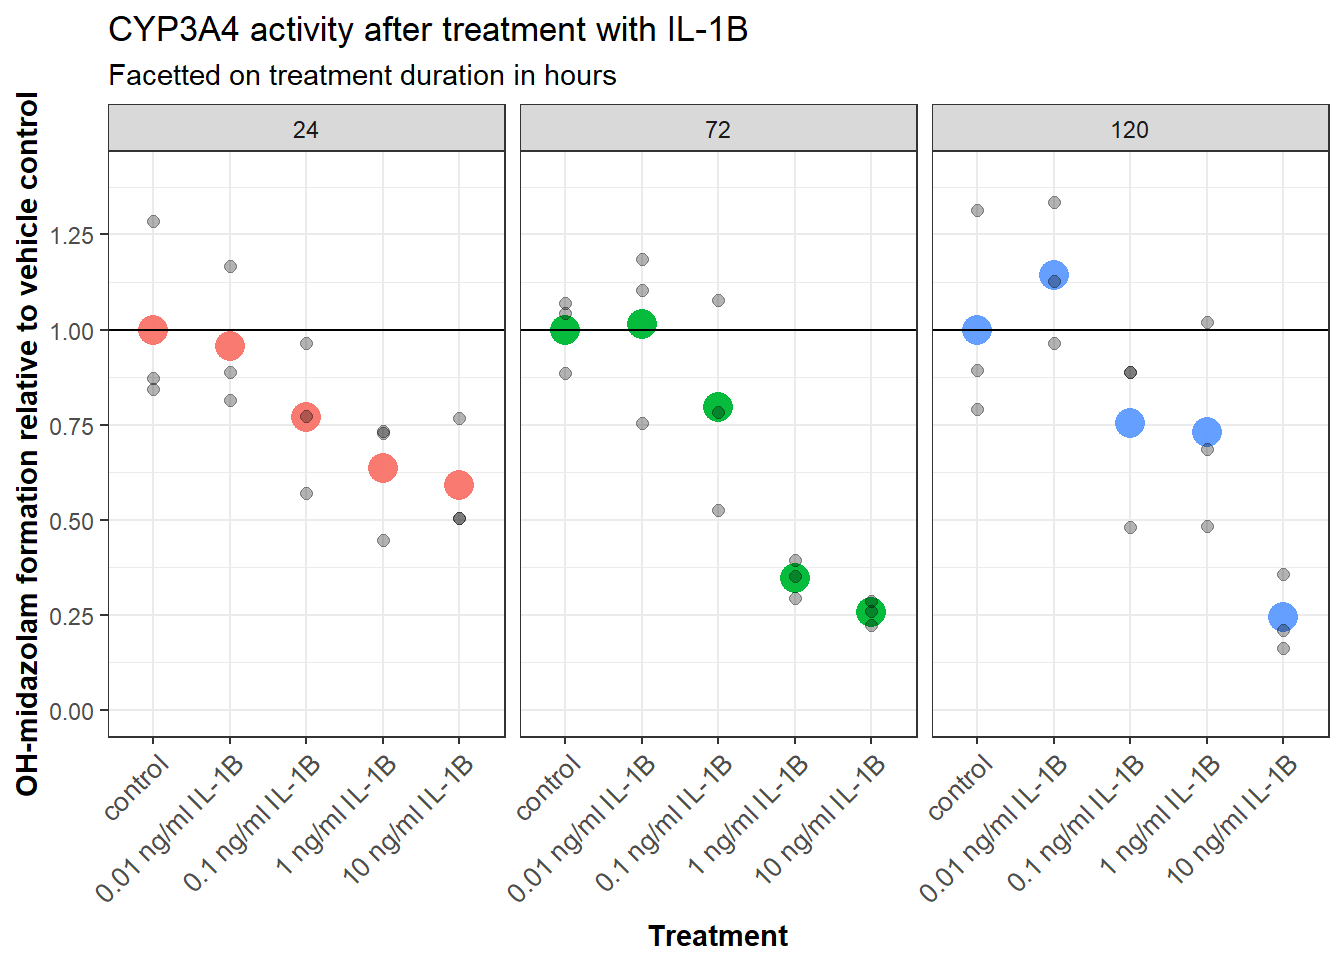

Saving 7 x 5 in image

In [ ]:
plot_data <- tidy_data[time_incubation == 0.5 &
  treatment %in% group_IL1B]

act_3A4_IL_1B_AS0013 <- 
ggplot(data = plot_data) +
  geom_point(
    aes(
      x = treatment,
      y = mean_relative_amount,
      color = factor(time_treatment)
    ),
    size = 5,
    alpha = 0.7
  ) +
  geom_point(
    aes(
      x = treatment,
      y = relative_amount
    ),
    size = 2,
    alpha = 0.3
  ) +
  geom_hline(yintercept = 1) +
  scale_y_continuous(
    name = "OH-midazolam formation relative to vehicle control", 
    breaks = seq(from = 0, to = 1.5, by= 0.25), limits = c(0, 1.4)
    ) +
  facet_wrap(
    facets = vars(factor(time_treatment))
  ) +
  theme_bw() +
  xlab("Treatment") + 
  ggtitle("CYP3A4 activity after treatment with IL-1B",
          subtitle = "Facetted on treatment duration in hours") +
  ylab("Metabolite formation relative to vehicle control") +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
        axis.title.x = element_text(hjust = 0.5, vjust = 0, face = "bold"),
        axis.title.y = element_text(face = "bold"),
        legend.position = "none"
  )

act_3A4_IL_1B_AS0013


## Donor 2, AS0008, midazolam

**Load data**

In [ ]:

# Ignore warnings. Just NA's as expected
data <-
  read_excel(
    path = here("notebooks/LCMS/data_raw/220506_AS008_v1_Short.xlsx"),
    sheet = "Hydroxymidazolam",
    skip = 4,
    col_types = c(
      "text", "skip", "skip", "skip",
      "skip", "skip", "skip", "skip",
      "numeric", "skip", "skip", "text",
      "skip", "skip", "skip", "skip"
    ),
    col_names = c("sample_name", "amount", "peak_status")
  )


In [ ]:
sample_info <- read_excel(here("notebooks/LCMS/data_raw/AS0008_sample_info.xlsx"))

tidy_data <- merge.data.table(data, sample_info, by = "sample_name")

# Check dt structure
str(tidy_data)


Classes 'data.table' and 'data.frame':  120 obs. of  9 variables:
 $ sample_name    : chr  "AS0008_109" "AS0008_110" "AS0008_111" "AS0008_112" ...
 $ amount         : num  7.71 7.6 7.3 6.63 4.6 ...
 $ peak_status    : chr  NA NA NA NA ...
 $ metabolite     : chr  "Hydroxymidazolam" "Hydroxymidazolam" "Hydroxymidazolam" "Hydroxymidazolam" ...
 $ donor          : num  2 2 2 2 2 2 2 2 2 2 ...
 $ treatment      : chr  "medium" "control" "0.01 ng/ml IL-6" "0.1 ng/ml IL-6" ...
 $ time_treatment : num  72 72 72 72 72 72 72 72 72 72 ...
 $ time_incubation: num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ rep            : num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "sample_name"

Check peak status’ for any amounts below what below/above the limit of our standard curve.

In [ ]:
# Check peak status'
unique(tidy_data$peak_status)


[1] NA             "Response Low" "Not Found"   

   sample_name     amount  peak_status       metabolite donor       treatment
1:  AS0008_135  0.9118640 Response Low Hydroxymidazolam     2   10 ng/ml IL-6
2:  AS0008_152         NA    Not Found Hydroxymidazolam     2   1 ng/ml IL-1B
3:  AS0008_153         NA    Not Found Hydroxymidazolam     2  10 ng/ml IL-1B
4:  AS0008_162         NA    Not Found Hydroxymidazolam     2   1 ng/ml IL-1B
5:  AS0008_163         NA    Not Found Hydroxymidazolam     2  10 ng/ml IL-1B
6:  AS0008_171 -0.2901863 Response Low Hydroxymidazolam     2 0.1 ng/ml IL-1B
7:  AS0008_172         NA    Not Found Hydroxymidazolam     2   1 ng/ml IL-1B
8:  AS0008_173         NA    Not Found Hydroxymidazolam     2  10 ng/ml IL-1B
9:  AS0008_197  0.8381536 Response Low Hydroxymidazolam     2   10 ng/ml IL-6
   time_treatment time_incubation rep
1:             72             0.5   3
2:             72             8.0   1
3:             72             8.0   1
4:             72             8.0   2
5:             72             

  ------------------------------------------------------------------------------------------------------------------------
  sample_name         amount peak_status   metabolite           donor treatment     time_treatment   time_incubation   rep
  ------------- ------------ ------------- ------------------ ------- ----------- ---------------- ----------------- -----
  AS0008_152              NA Not Found     Hydroxymidazolam         2 1 ng/ml                   72                 8     1
                                                                      IL-1B                                          

  AS0008_153              NA Not Found     Hydroxymidazolam         2 10 ng/ml                  72                 8     1
                                                                      IL-1B                                          

  AS0008_162              NA Not Found     Hydroxymidazolam         2 1 ng/ml                   72                 8     2
                                                                      IL-1B                                          

  AS0008_163              NA Not Found     Hydroxymidazolam         2 10 ng/ml                  72                 8     2
                                                                      IL-1B                                          

  AS0008_171      -0.2901863 Response Low  Hydroxymidazolam         2 0.1 ng/ml                 72                 8     3
                                                                      IL-1B                                          

  AS0008_172              NA Not Found     Hydroxymidazolam         2 1 ng/ml                   72                 8     3
                                                                      IL-1B                                          

  AS0008_173              NA Not Found     Hydroxymidazolam         2 10 ng/ml                  72                 8     3
                                                                      IL-1B                                          
  ------------------------------------------------------------------------------------------------------------------------


#### Same as for other donor, should the response low samples be removed? It is below the lowest point on our standard curve, but omitting it would make the mean higher, than it really is?

**Mean of replicates and activity relative to vehicle control**

In [ ]:
# Calculate the mean amount of replicates
tidy_data[, 
          mean_amount := mean(amount, na.rm = TRUE), 
          by = .(treatment, time_treatment, time_incubation)
          ]


# Add column with control mean amounts grouped by time_treatment and time_incubation
tidy_data[,
          control_mean_amount := mean(mean_amount[treatment == "control"]),
          by = .(time_treatment, time_incubation)
          ]

# Calculate both amounts and mean_amounts relative to control
tidy_data[,
          `:=`(
            relative_amount = amount / control_mean_amount,
            mean_relative_amount = mean_amount / control_mean_amount
            )
          ]


**Save the data**

In [ ]:
saveRDS(tidy_data, file = here("notebooks/LCMS/data_processed/AS0008.rds"))


#### **Plots**

In [ ]:
tidy_data <- readRDS(here("notebooks/LCMS/data_processed/AS0008.rds"))


In [ ]:
# Create groups/look up tables for subsetting data
group_IL6 <- c("control", 
               #"medium", 
               "0.01 ng/ml IL-6", 
               "0.1 ng/ml IL-6",
               "1 ng/ml IL-6", 
               "10 ng/ml IL-6"
               )

group_IL1B <- c("control", 
                #"medium", 
                "0.01 ng/ml IL-1B", 
                "0.1 ng/ml IL-1B",
                "1 ng/ml IL-1B",
                "10 ng/ml IL-1B"
                )


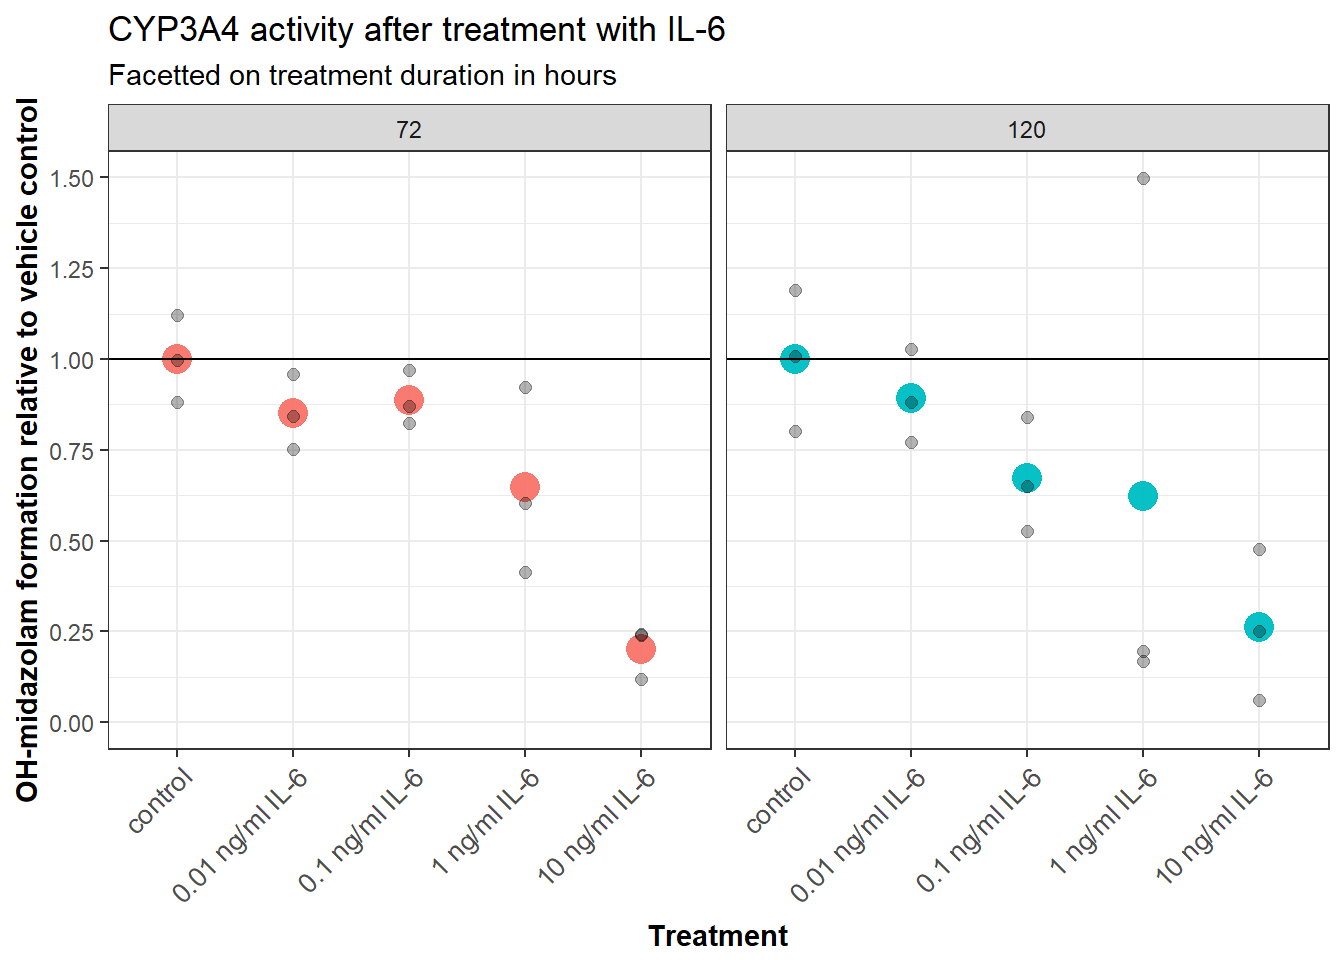

Saving 7 x 5 in image

In [ ]:
plot_data <- tidy_data[time_incubation == 0.5 &
  treatment %in% group_IL6]

act_3A4_IL_6_AS008 <- 
ggplot(data = plot_data) +
  geom_point(
    aes(
      x = treatment,
      y = mean_relative_amount,
      color = factor(time_treatment)
    ),
    size = 5,
    alpha = 0.7
  ) +
  geom_point(
    aes(
      x = treatment,
      y = relative_amount
    ),
    size = 2,
    alpha = 0.3
  ) +
  geom_hline(yintercept = 1) +
  scale_y_continuous(
    name = "OH-midazolam formation relative to vehicle control", 
    breaks = seq(from = 0, to = 1.5, by= 0.25), limits = c(0, NA)
    ) +
  facet_wrap(
    facets = vars(factor(time_treatment))
  ) +
  theme_bw() +
  xlab("Treatment") + 
  ggtitle("CYP3A4 activity after treatment with IL-6",
          subtitle = "Facetted on treatment duration in hours") +
  ylab("Metabolite formation relative to vehicle control") +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
        axis.title.x = element_text(hjust = 0.5, vjust = 0, face = "bold"),
        axis.title.y = element_text(face = "bold"),
        legend.position = "none"
  )

act_3A4_IL_6_AS008


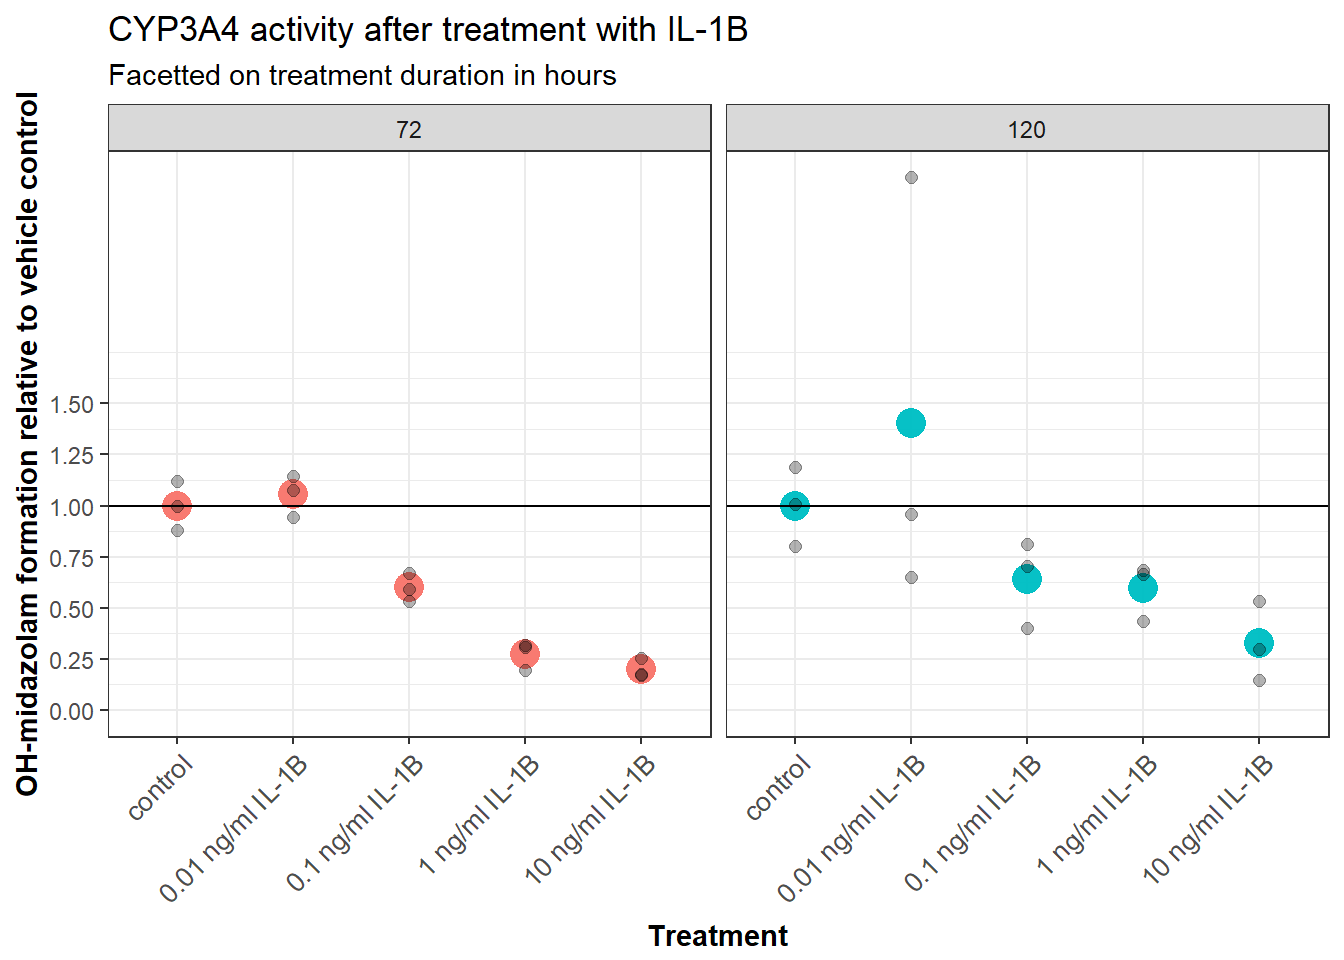

Saving 7 x 5 in image

In [ ]:
plot_data <- tidy_data[time_incubation == 0.5 &
  treatment %in% group_IL1B]

act_3A4_IL_1B_AS008 <- 
ggplot(data = plot_data) +
  geom_point(
    aes(
      x = treatment,
      y = mean_relative_amount,
      color = factor(time_treatment)
    ),
    size = 5,
    alpha = 0.7
  ) +
  geom_point(
    aes(
      x = treatment,
      y = relative_amount
    ),
    size = 2,
    alpha = 0.3
  ) +
  geom_hline(yintercept = 1) +
  scale_y_continuous(
    name = "OH-midazolam formation relative to vehicle control", 
    breaks = seq(from = 0, to = 1.5, by= 0.25), limits = c(0, NA)
    ) +
  facet_wrap(
    facets = vars(factor(time_treatment))
  ) +
  theme_bw() +
  xlab("Treatment") + 
  ggtitle("CYP3A4 activity after treatment with IL-1B",
          subtitle = "Facetted on treatment duration in hours") +
  ylab("Metabolite formation relative to vehicle control") +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
        axis.title.x = element_text(hjust = 0.5, vjust = 0, face = "bold"),
        axis.title.y = element_text(face = "bold"),
        legend.position = "none"
  )

act_3A4_IL_1B_AS008


## Combine and save final dataframe

In [ ]:
files <- fs::dir_ls(here("notebooks/LCMS/data_processed"), regexp = "AS")

data <- lapply(files, readRDS)

final_data <- rbindlist(data, idcol = "file")
final_data[, file := gsub(pattern = "notebooks/LCMS/data_processed/", replacement = "", file)]

saveRDS(final_data, file = here("notebooks/LCMS/data_processed/final_data.rds"))


## Main plots

load data

In [ ]:
data <- readRDS(here("notebooks/LCMS/data_processed/final_data.rds"))


In [ ]:
# Create groups/look up tables for subsetting data
group_IL6 <- c("control", 
               #"medium", 
               "0.01 ng/ml IL-6", 
               "0.1 ng/ml IL-6",
               "1 ng/ml IL-6", 
               "10 ng/ml IL-6"
               )

group_IL1B <- c("control", 
                #"medium", 
                "0.01 ng/ml IL-1B", 
                "0.1 ng/ml IL-1B",
                "1 ng/ml IL-1B",
                "10 ng/ml IL-1B"
                )


IL-6

In [ ]:
plot_data_IL6 <- data[time_incubation == 0.5 
                      & treatment %in% group_IL6
                      & time_treatment != 24]


act_3A4_IL6 <- ggplot(data = plot_data_IL6) +
  geom_point(
    mapping = aes(x = treatment, y = mean_relative_amount, color = factor(time_treatment)),
    size = 3.5
  ) +
  stat_summary(
    fun = "mean",
    geom = "point",
    mapping = aes(x = treatment, y = mean_relative_amount),
    size = 5
  ) +
  facet_wrap(~ time_treatment, labeller = labeller(time_treatment = paste("time", as.character()))) +
  labs(title = "CYP3A4 activity relative to vehicle control after IL-6 treatment") + 
  xlab("Treatment") + 
  ylab("Relative activity") +
  scale_y_continuous(limits = c(0, NA))


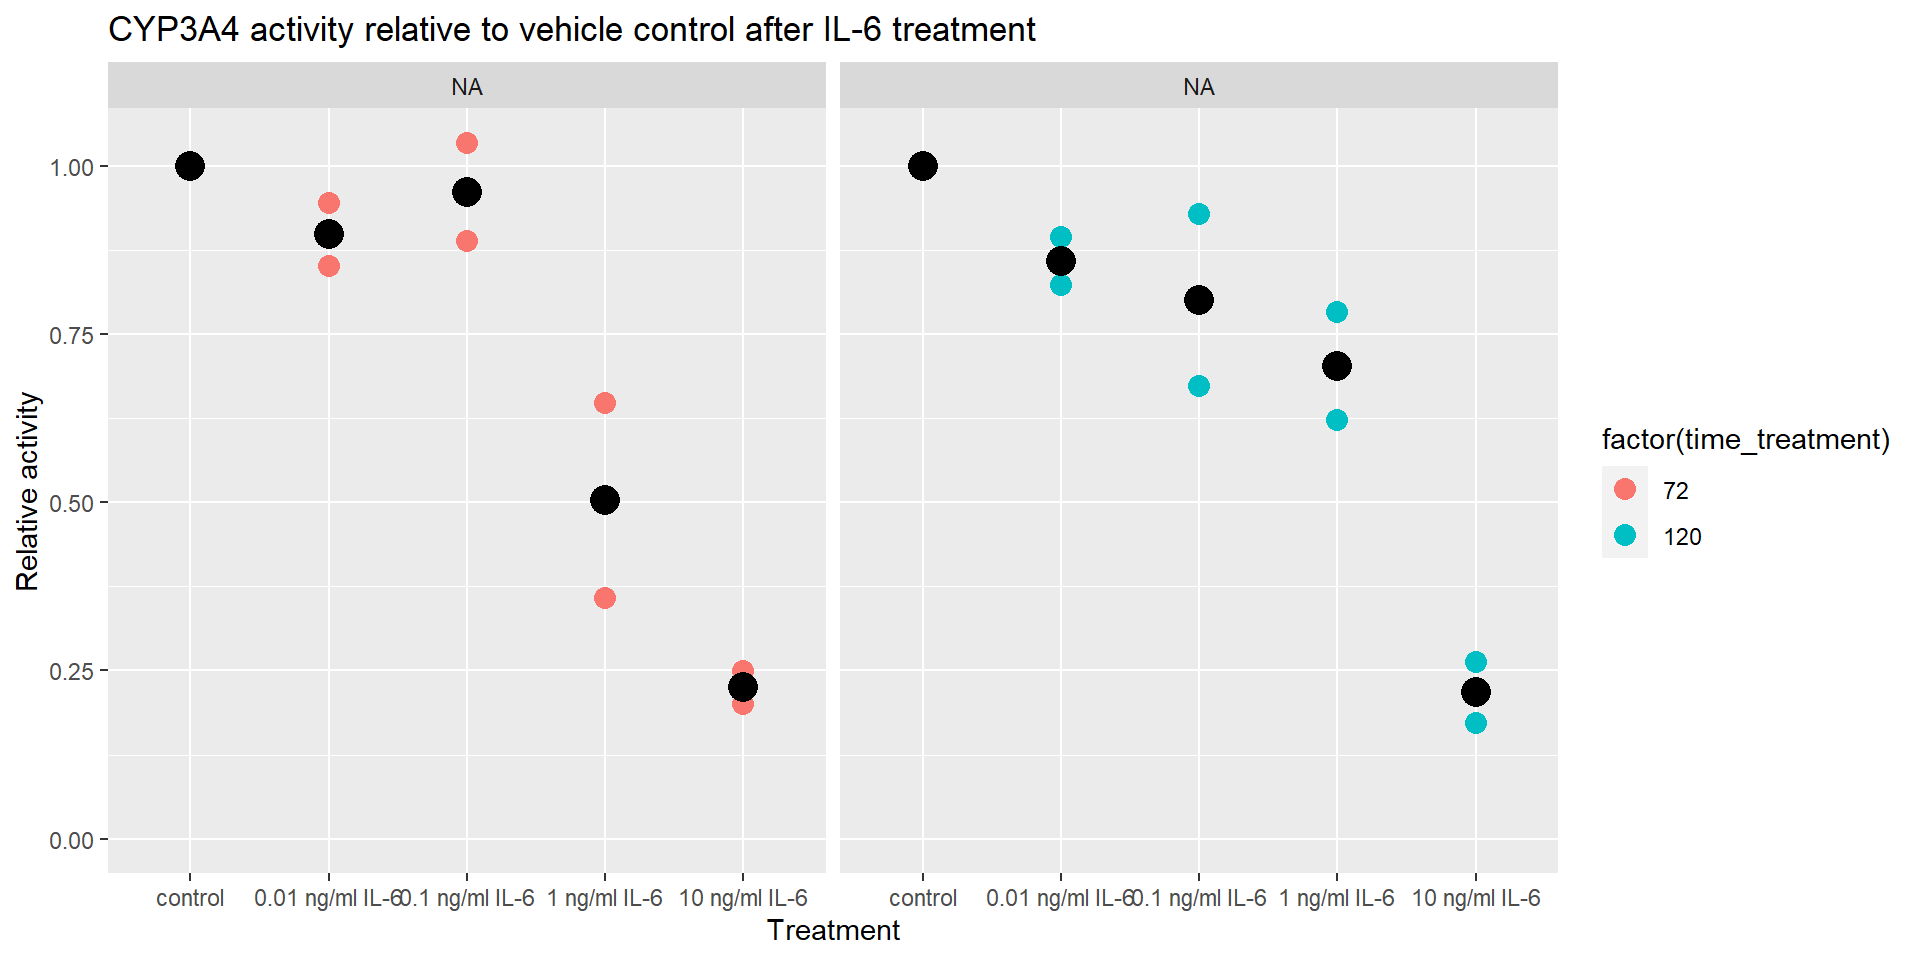

In [ ]:

act_3A4_IL6


CONSIDER REMOVING THE OUTLIER IN 120 hour IL-6 and IL1B. See the individual plots above.

IL-1B

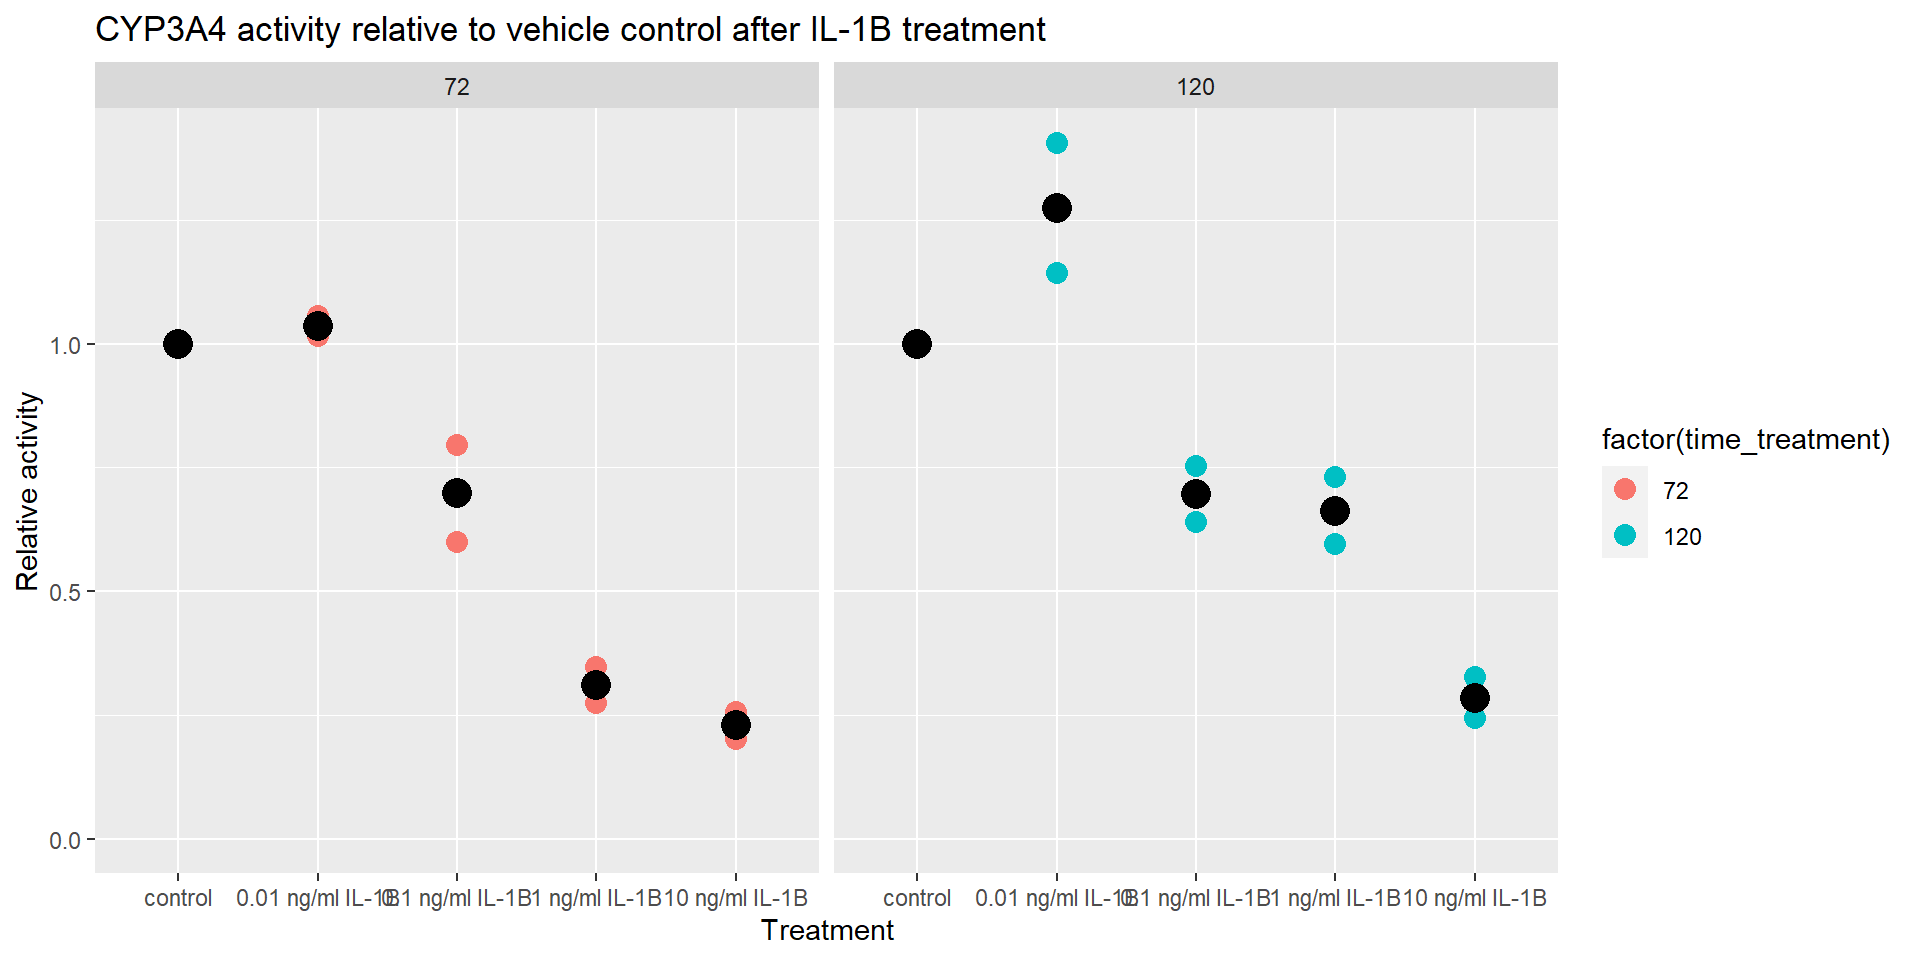

In [ ]:

plot_data_I1B <- data[time_incubation == 0.5 
                      & treatment %in% group_IL1B
                      & time_treatment != 24]


ggplot(data = plot_data_I1B) +
  geom_point(
    mapping = aes(x = treatment, y = mean_relative_amount, color = factor(time_treatment)),
    size = 3.5
  ) +
  stat_summary(
    fun = "mean",
    geom = "point",
    mapping = aes(x = treatment, y = mean_relative_amount),
    size = 5
  ) +
  facet_wrap(facets = vars(time_treatment)) +
  labs(title = "CYP3A4 activity relative to vehicle control after IL-1B treatment") + 
  xlab("Treatment") + 
  ylab("Relative activity")  +
  scale_y_continuous(limits = c(0, NA))


## EC50